# One-Point Distribution Function Calculation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import product, repeat
from scipy.special import gamma
from scipy.optimize import newton

## Cosmology Object

Instantces of class `cosmology` store parameters for a flat $\Lambda$-CDM cosmology. This class also defines the functions like $E(z)$, the growth factor etc. Growth factor is computed by the approximate form given by Carroll et al (1992). Power spectrum model is the Eisenstein-Hu no BAO model.

In [2]:
class cosmology:
    """ A flat lambda-cdm cosmology class. """
    __slots__ = 'Om0', 'Ob0', 'Ode0', 'h', 'ns', 'sigma8', 'Tcmb0', '_pknorm', 

    def __init__(self, Om0: float, Ob0: float, h: float, ns: float = 1.0, sigma8: float = 0.8, Tcmb0: float = 2.275) -> None:
        assert 0.0 <= Om0,        "Om0 cannot be negative" 
        assert 0.0 <= Ob0 <= Om0, "Ob0 cannot negative or greater than Om0"
        assert 0.0 <= h,          "h cannot be negative" 
        assert 0.0 <  Tcmb0,      "Tcmb0 cannot be negative" 

        self.Om0, self.Ob0 = Om0, Ob0  # matter and baryon densities
        self.Ode0          = 1.0 - Om0 # dark-energy density
        self.h             = h         # hubble parameter
        self.Tcmb0         = Tcmb0     # cmb temperature 
        self.ns            = ns        # power spectrum slope
        self.sigma8        = sigma8    # rms variance of fluctuations at 8 Mpc/h
        self._pknorm       = 1.0       # power spectrum normalization

        self.normalize()

    @property
    def H0(self) -> float:
        """ Present hubble parameter in km/s/Mpc. """
        return 100.0 * self.h
    
    def __repr__(self) -> str:
        return f"cosmology(Om0={self.Om0}, Ob0={self.Ob0}, Ode0={self.Ode0}, h={self.h}, ns={self.ns}, sigma8={self.sigma8}, Tcmb0={self.Tcmb0}K)"

    def Ez(self, z: float) -> float:
        """ Hubble parameter per its present value. """
        zp1 = np.asarray(z) + 1
        return np.sqrt(self.Om0 * zp1**3 + self.Ode0)

    def Om(self, z: float) -> float:
        """ Matter density. """
        zp1 = np.asarray(z) + 1
        Omz = self.Om0 * zp1**3
        return Omz / (Omz + self.Ode0)

    def Ode(self, z: float) -> float:
        """ Dark-energy density. """
        zp1 = np.asarray(z) + 1
        return self.Ode0 / (self.Om0 * zp1**3 + self.Ode0)

    def _Dz(self, z: float) -> float:
        zp1 = np.asarray(z) + 1

        # calculate the matter and dark-energy densities 
        Omz, Odez = self.Om0 * zp1**3, self.Ode0
        Ez2       = Omz + Odez
        Omz, Odez = Omz / Ez2, Odez / Ez2

        # growth factor using approximation by carroll et al (1992)
        Dz = 2.5 * Omz / zp1 / (Omz**(4./7.) - Odez + (1 + Omz / 2) * (1 + Odez / 70))
        return Dz

    def Dz(self, z: float) -> float:
        """ Linear growth factor using the approximate form. """
        return self._Dz(z) / self._Dz(0) 

    def fz(self, z: float) -> float:
        """ Linear growth rate using the approximate form. """
        return self.Om(z)**0.6

    def transfer(self, k: float) -> float:
        """ Linear transfer function (EH no BAO model). """
        k           = np.asarray(k)
        Omh2, Obh2  = np.array([self.Om0, self.Ob0]) * self.h**2
        theta       = self.Tcmb0 / 2.7
        wt_b        = self.Ob0 / self.Om0
        s           = 44.5 * np.log(9.83 / Omh2) / np.sqrt(1 + 10 * Obh2**(3/4))
        alpha_gamma = 1 - 0.328 * np.log(431 * Omh2) * wt_b + 0.38 * np.log(22.3 * Omh2) * wt_b**2
        gamma_eff   = self.Om0 * self.h * (alpha_gamma + (1 - alpha_gamma)/(1 + (0.43 * k * s)**4))
        q           = k * (theta * theta/ gamma_eff)
        l0, c0      = np.log(2 * np.e + 1.8 * q), 14.2 + 731.0 / (1 + 62.5 * q)
        return l0 / (l0 + c0 * q**2)

    def _unn0_matterPowerSpectrum(self, k: float) -> float:
        k = np.asarray(k)
        return self.transfer(k)**2 * k**self.ns

    def _unn0_variance(self, r: float, ka: float = 1e-8, kb: float = 1e+8, n: int = 1001) -> float:
        r = np.asarray(r)

        # integration setup:
        assert n % 2 and n > 2, "n must be an odd number greater than 2"
        assert ka < kb,         "kb must be greater than ka"
        assert ka > 0,          "ka and kb must be positive"

        lnka, lnkb = np.log(ka), np.log(kb)             # lower and upper limits
        dlnk       = (lnkb - lnka) / (n-1)              # step-size
        k          = np.exp(np.linspace(lnka, lnkb, n)) # integration nodes

        def filt(x):
            """ spherical top-hat filter. """
            return (np.sin(x) - x * np.cos(x)) * 3. / x**3 

        # integration is in log(k) using simpson rule
        kr     = np.outer(r, k)
        y      = k**3 * self._unn0_matterPowerSpectrum(k) * filt(kr)**2 # integrand
        retval = (y[:, :-1:2].sum(-1) + 4 * y[:, 1::2].sum(-1) + y[:, 2::2].sum(-1)) * dlnk / 3

        return (retval if np.ndim(r) else retval[0]) / 2. / np.pi**2 # variance

    def matterPowerSpectrum(self, k: float, z: float = 0.0) -> float:
        """ Linear matter power spectrum (EH no BAO model). """
        assert np.ndim(z) == 0, "z must be a scalar"
        return self._pknorm * self._unn0_matterPowerSpectrum(k) * self.Dz(z)

    def variance(self, r: float, z: float = 0.0, ka: float = 1e-8, kb: float = 1e+8, n: int = 1001) -> float:
        """ Linear matter variance. """
        assert np.ndim(z) == 0, "z must be a scalar"
        return self._pknorm * self._unn0_variance(r, ka, kb, n) * self.Dz(z)

    def normalize(self, sigma8: float = ..., ka: float = 1e-8, kb: float = 1e+8, n: int = 1001) -> None:
        """ Normalise power spectrum. """
        sigma8 = self.sigma8 if sigma8 is ... else sigma8
        assert sigma8 is not ..., "sigma8 must be given"
        self._pknorm = 1.0
        self._pknorm = sigma8**2 / self._unn0_variance(8.0, ka, kb, n)
        self.sigma8  = sigma8
        

Example: cosmology with $H_0 = 70$ km/s/Mpc, $\Omega_m = 0.3$, $\Omega_b = 0.05$ and $\Omega_{de} = 0.7$. 

In [3]:
c = cosmology(Om0 = 0.3, Ob0 = 0.05, h = 0.70)
c

cosmology(Om0=0.3, Ob0=0.05, Ode0=0.7, h=0.7, ns=1.0, sigma8=0.8, Tcmb0=2.275K)

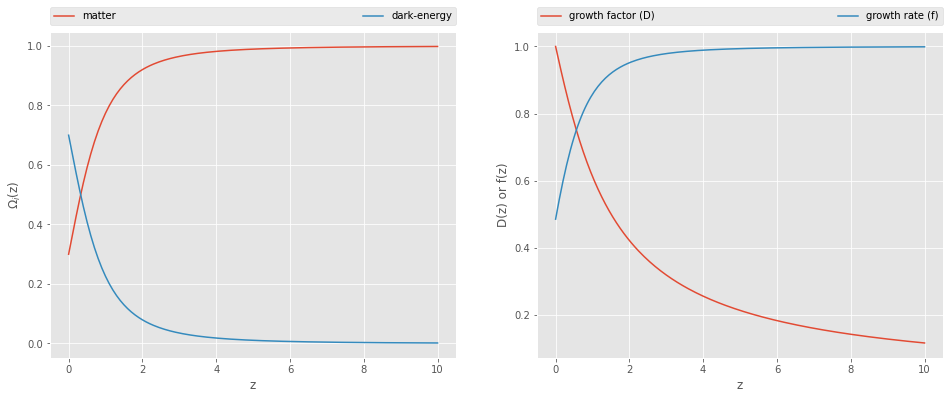

In [4]:
def drawDensityGrowth(c: cosmology):
    """ draw densities and growth factor. """
    z = np.linspace(0, 10, 201)



    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6),)


    ax1.plot(z, c.Om(z),  label = 'matter')
    ax1.plot(z, c.Ode(z), label = 'dark-energy')
    ax1.set_xlabel('z'); ax1.set_ylabel('$\Omega_i$(z)')
    ax1.legend(
                bbox_to_anchor = (0., 1.02, 1., .102), loc = 'lower left', 
                ncol = 2, mode = "expand", borderaxespad = 0.
              )

    ax2.plot(z, c.Dz(z), label = 'growth factor (D)')
    ax2.plot(z, c.fz(z), label = 'growth rate (f)')
    ax2.set_xlabel('z'); ax2.set_ylabel('D(z) or f(z)')
    ax2.legend(
                bbox_to_anchor = (0., 1.02, 1., .102), loc = 'lower left', 
                ncol = 2, mode = "expand", borderaxespad = 0.
              )

    plt.show()

drawDensityGrowth(c)

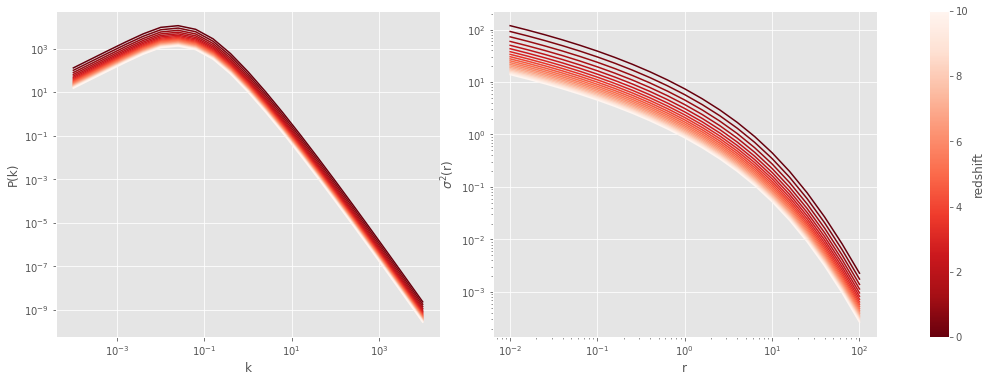

In [5]:
def drawPowerVariance(c: cosmology):
    """ plot power spectrum and variance. """
    z  = np.linspace(0, 10, 21)
    k  = np.logspace(-4, 4, 21)
    r  = np.logspace(-2, 2, 21)

    # creating a colormap
    from matplotlib import colors, cm 
    cmap = cm.ScalarMappable(
                                norm = colors.Normalize(z.min(), z.max(), ),
                                cmap = cm.Reds_r
                            )
    cmap.set_array([])

    fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize = (16, 6), 
                                        gridspec_kw = {"width_ratios":[1, 1, 0.05]})

    ax1.loglog(); ax2.loglog()

    for zi in z:
        ax1.plot(k, c.matterPowerSpectrum(k, zi), '-', color = cmap.to_rgba(zi))
        ax2.plot(r, c.variance(r, zi), '-', color = cmap.to_rgba(zi))

    ax1.set_xlabel('k'); ax1.set_ylabel('P(k)')
    ax2.set_xlabel('r'); ax2.set_ylabel('$\sigma^2$(r)')

    plt.colorbar(cmap, cax = cax, orientation = "vertical")
    cax.set_ylabel('redshift')

    plt.show()

drawPowerVariance(c)

## Quantities Related to One-Point Distribution (Test)

### Linear variance in the cell

For a cubic cell of sidelength $l$, linear variance is given by 

$$ \sigma_{\rm lin}^2 (k_N) = \frac{1}{2\pi^2} \int_0^{k_N} k^2 P_{\rm lin}(k) {\rm d}k, \quad k_N = l / \pi $$

Changing the integration variable to $q = \log k$,

$$ \sigma_{\rm lin}^2 (k_N) = \frac{1}{2\pi^2} \int_0^{q=\log k_N} k^3 P_{\rm lin}(k) {\rm d}q $$


In [6]:
def test_cellLinearVariance(cellsize: float, c: cosmology, z: float = 0.0, ka: float = 1e-8, n: int = 1001, show: bool = False) -> float:
    """ calculate cell linear variance. """
    assert np.ndim(cellsize) == 0, "cellsize must be a scalar"
    kn = np.pi / cellsize

    # integration setup:
    assert n % 2 and n > 2, "n must be an odd number greater than 2"
    assert ka < kn,         "kb must be greater than ka"
    assert ka > 0,          "ka and kb must be positive"

    lnka, lnkb = np.log(ka), np.log(kn)             # lower and upper limits
    dlnk       = (lnkb - lnka) / (n-1)              # step-size
    k          = np.exp(np.linspace(lnka, lnkb, n)) # integration nodes

    y      = k**3 * c.matterPowerSpectrum(k, z)  / 2. / np.pi**2 # integrand
    retval = (y[:-1:2].sum(-1) + 4 * y[1::2].sum(-1) + y[2::2].sum(-1)) * dlnk / 3

    if show:
        plt.figure(figsize = [8,6])
        plt.loglog(k, y)
        plt.xlabel('k'); plt.ylabel('$P(k)k^3$')
        plt.show()

    return retval



vlin = test_cellLinearVariance(1.95, c, 0.0) # linear variance at l = 1.95 Mpc/h
vlin

6.622332726953746

### Variance of the Log Field

The log field is given as $A = \log(1+\delta)$ is related to the linear variance through the fit

$$ \sigma^2_A (k_N) = \mu \log \left( 1 + \frac{\sigma^2_{\rm lin}(k_N)}{\mu} \right) $$

with the best-fit value, $\mu = 0.73$.

In [7]:
def test_logVariance(vlin: float, mu: float = 0.73) -> float:
    """ log field variance. """
    return mu * np.log(1. + vlin / mu)

vlog = test_logVariance(vlin) # log variance at l = 1.95 Mpc/h
vlog

1.6861017214351453

### Log Field Bias

Log field bias is given by 

$$ b_A^2 = \frac{\sigma_A^2 (k_N)}{\sigma_{\rm lin}^2 (k_N)} $$

Then, the log field power spectrum is related to the linear matter power spectrum as 

$$ P_A(k) = b_A^2 P_{\rm lin}(k) $$

In [8]:
blog2 = vlog / vlin
blog2

0.2546084274159911

### Measured Count-in-Cell Power Spectrum

Count-in-cell introduces a convolution of over-density signal with real-space cubical top-hat filter. This introduce a factor of $W^2(k)$ in the variance equation. This factor is given by the mass assignment function

$$ W({\bf k}) = \prod_{i=x,y,z} {\rm sinc}^p \left( \frac{k_i}{2 k_n} \right) $$

where ${\rm sinc}(x) = \sin(\pi x) / (\pi x)$ is the normalised 'sinc' function and $p=1$ is correspond to NGC mass assignment. 

The measured power spectrum is then given as

$$ P_{A, \rm meas}({\bf k}) = \sum_{{\bf n} \in \Z^3} P_A({\bf k} + 2k_N{\bf n}) W^2({\bf k} + 2k_N{\bf n}) $$

where $\vert {\bf n} \vert < 3$ and this equation is valid when $\vert {\bf k} \vert \le k_N$. After that, a power law continuation of the form $P_{A, \rm meas}({\bf k}) = a \vert {\bf k} \vert^b $ is used to get the power.

In [9]:
class measpower:
    """ unbiased (b = 1) measured power spectrum at z = 0. """
    __slots__ = 'a', 'b', 'cellsize', 'kn', 'cosmo'

    def __init__(self, cellsize: float, c: cosmology) -> None:
        self.a, self.b = 0.0, 0.0
        self.cellsize  = cellsize
        self.kn        = np.pi / cellsize
        self.cosmo     = c
        self.getContinuation()

    def cubicTophat(self, kx: float, ky: float, kz: float) -> float:
        """ cubic top-hat filter in real space. """
        kx, ky, kz = np.asarray(kx), np.asarray(ky), np.asarray(kz)
        return np.sinc(kx / 2. / self.kn) * np.sinc(ky / 2. / self.kn) * np.sinc(kz / 2. / self.kn)

    def matterPowerSpectrum(self, kx: float, ky: float, kz: float) -> float:
        """ linear power spectrum """
        kx, ky, kz = np.asarray(kx), np.asarray(ky), np.asarray(kz)
        return self.cosmo.matterPowerSpectrum(np.sqrt(kx**2 + ky**2 + kz**2), 0.0)

    def powerTerm(self, kx: float, ky: float, kz: float) -> float:
        """ a term in the power spectrum sum. """
        return self.matterPowerSpectrum(kx, ky, kz) * self.cubicTophat(kx, ky, kz)**2

    def powerInsideSphere(self, kx: float, ky: float, kz: float) -> float:
        """ power spectrum for k-vectors inside the sphere of radius kn. """
        kx, ky, kz = np.asarray(kx), np.asarray(ky), np.asarray(kz)
        measpower  = 0.
        for nx, ny, nz in product(*repeat(range(3), 3)):
            if nx*nx + ny*ny + nz*nz >= 9.0:
                continue
            measpower += self.powerTerm(
                                            kx + 2.0 * self.kn * nx,
                                            ky + 2.0 * self.kn * ny,
                                            kz + 2.0 * self.kn * nz,
                                        )
        return measpower

    def getContinuation(self, npoints: int = 100_000, __use_scipy: bool = False) -> None:
        """ get the power law continuation. """
        # generate some points in log(k)-log(pk) plane:
        # NOTE: using the 50-70% of the kn for finding the continuation and using the
        # continuation when k > 60% of kn. equation is valid upto k < kn. 
        lnk        = np.random.uniform(np.log(0.5), np.log(0.7), npoints) + np.log(self.kn)
        theta      = np.random.uniform(0.0,   np.pi, npoints)
        phi        = np.random.uniform(0.0, 2*np.pi, npoints)
        kx, ky, kz = np.exp(lnk) * np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
        lnpm       = np.log(self.powerInsideSphere(kx, ky, kz))   
        
        # find the linear regression lnpm ~ lna + b * lnk
        if __use_scipy:
            from scipy.stats import linregress
            
            b, lna, rval, pval, stderr = linregress(lnk, lnpm) # using scypy.stats.linregress
        else:
            b, lna = np.polyfit(lnk, lnpm, deg = 1) # using numpy.polyfit
        
        self.a, self.b = np.exp(lna), b

    def powerOutsideSphere(self, k: float) -> float:
        """ power spectrum for k-vectors outside the sphere of radius kn. """
        return self.a * np.asarray(k)**self.b

    def measuredPowerSpectrum(self, kx: float, ky: float, kz: float) -> float:
        """ measured power spectrum with continuation. """
        kx, ky, kz = np.asarray(kx), np.asarray(ky), np.asarray(kz)
        out        = np.sqrt(kx**2 + ky**2 + kz**2) # k, overwritten by p values
        mask       = (out <= self.kn * 0.6)
        out[~mask] = self.powerOutsideSphere(out[~mask])
        out[mask]  = self.powerInsideSphere(kx[mask], ky[mask], kz[mask])
        return out

continuation: P(k) = 63.052 k^(-2.736)


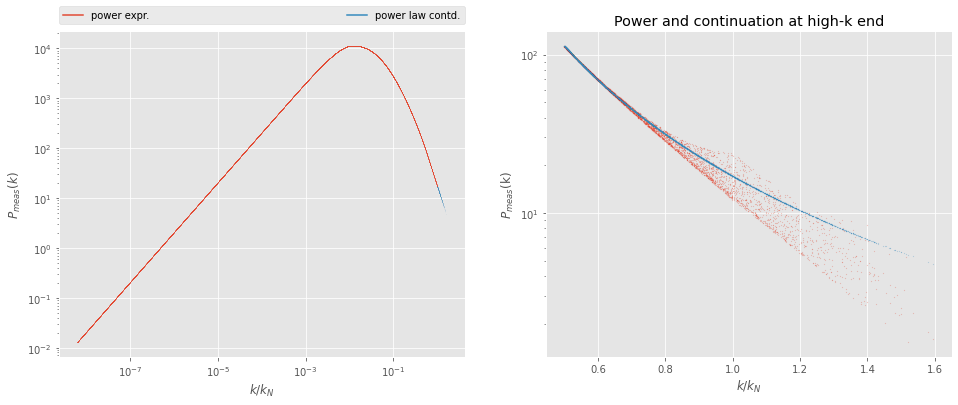

In [10]:
def drawMeasuredPowerVariance():
    """ plot measured power and variance. """
    mp = measpower(1.95, c)

    # generate some random k-vectors: 
    npoints    = 1_000_00
    kx         = np.random.uniform(-8, np.log10(np.sqrt(3) * mp.kn), npoints) # k, over-written by kx
    ky         = np.random.uniform(0.0,   np.pi, npoints)                     # theta, over-written by ky
    kz         = np.random.uniform(0.0, 2*np.pi, npoints)                     # phi, over-written by kz
    kx, ky, kz = 10**kx * np.array([np.sin(ky) * np.cos(kz), np.sin(ky) * np.sin(kz), np.cos(ky)])

    # restrict k-vectors to inside the cube:
    mask       = (
                    (-mp.kn <= kx) & (kx <= mp.kn) & # in x-range [-kn, kn]
                    (-mp.kn <= ky) & (ky <= mp.kn) & # in y-range [-kn, kn]
                    (-mp.kn <= kz) & (kz <= mp.kn)   # in z-range [-kn, kn]
                 )
    kx, ky, kz = kx[mask], ky[mask], kz[mask]

    # get power:
    k          = np.sqrt(kx**2 + ky**2 + kz**2)
    pk         = mp.measuredPowerSpectrum(kx, ky, kz)
    pk_inside  = mp.powerInsideSphere(kx, ky, kz)       # power inside kn radius
    pk_outside = mp.powerOutsideSphere(k)               # ... outside kn radius

    print("continuation: P(k) = {a:.3f} k^({b:+.3f})".format(a = mp.a, b = mp.b))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

    ax1.loglog()

    mask = (k <= mp.kn)
    ax1.plot([], [], '-', color = 'C0', label = 'power expr.')
    ax1.plot([], [], '-', color = 'C1', label = 'power law contd.')
    ax1.plot(k[ mask] / mp.kn, pk[ mask], 'o', ms = 0.01, color = 'C0', )
    ax1.plot(k[~mask] / mp.kn, pk[~mask], 'o', ms = 0.01, color = 'C1', ) 

    ax1.set_xlabel('$k/k_N$'); ax1.set_ylabel('$P_{meas}(k)$')
    ax1.legend(
                bbox_to_anchor = (0., 1.02, 1., .102), loc = 'lower left', 
                ncol = 2, mode = "expand", borderaxespad = 0.
              )

    # drawing the large-k end:
    ax2.semilogy()

    mask = (k > mp.kn * 0.5)
    ax2.plot(k[mask] / mp.kn, pk_inside[mask], 'o', ms = 0.1, color = 'C0', )
    ax2.plot(k[mask] / mp.kn, pk_outside[mask], 'o', ms = 0.1, color = 'C1', ) 

    ax2.set_xlabel('$k/k_N$'); ax2.set_ylabel('$P_{meas}$(k)')
    ax2.set_title("Power and continuation at high-k end")

    plt.show()


drawMeasuredPowerVariance()

### Measured Count-in-Cells Variance

Measured CIC variance is given by the integral

$$ \sigma_A^2(l) = \int_{V} \frac{{\rm d}^3 k}{(2 \pi)^3} P_{A, \rm meas} ({\bf k}) $$

where $V$ is the region of integration, which is the cube with sides from $-k_N$ to $k_N$, excluding the zero vector. 

Using the naive monte-carlo method, this integral is

$$ \sigma_A^2(l) \approx \frac{1}{(2\pi)^3} \cdot \langle P_{A, \rm meas} \rangle V $$ 

In [11]:
def test_cicVariance(mp: measpower, n: int = 100_000, method: str = 'mc') -> float:
    """ get the measured cic variance in a cell. """
    if method == 'mc':
        # generate random k-vectors:
        kx         = np.random.uniform(-8, np.log10(np.sqrt(3) * mp.kn), n) # k, over-written by kx
        ky         = np.random.uniform(0.0,   np.pi, n)                     # theta, over-written by ky
        kz         = np.random.uniform(0.0, 2*np.pi, n)                     # phi, over-written by kz
        kx, ky, kz = 10**kx * np.array([np.sin(ky) * np.cos(kz), np.sin(ky) * np.sin(kz), np.cos(ky)])
        mask       = (
                        (-mp.kn <= kx) & (kx <= mp.kn) & # in x-range [-kn, kn]
                        (-mp.kn <= ky) & (ky <= mp.kn) & # in y-range [-kn, kn]
                        (-mp.kn <= kz) & (kz <= mp.kn)   # in z-range [-kn, kn]
                    )
        kx, ky, kz = kx[mask], ky[mask], kz[mask]

        pk = mp.measuredPowerSpectrum(kx, ky, kz)
        
        return pk.mean() * (mp.kn / np.pi)**3
    elif method == 'simps':
        assert n % 2 and n > 2, "n must be an odd number greater than 2"

        # generate k-grid
        lnka, lnkb = np.log(1e-8), np.log(mp.kn)        # lower and upper limits
        dlnk       = (lnkb - lnka) / (n-1)              # step-size
        f          = np.exp(np.linspace(lnka, lnkb, n)) # integration nodes in one diretion
        f, ky, kz  = np.meshgrid(f, f, f)               # all integration nodes (one octant)

        f = f * ky * kz * mp.measuredPowerSpectrum(f, ky, kz)
        del ky, kz                                      # delete variables ky and kz

        f = f[:,:,:-1:2].sum(-1) + 4 * f[:,:,1::2].sum(-1) + f[:,:,2::2].sum(-1)
        f = f[:,:-1:2].sum(-1) + 4 * f[:,1::2].sum(-1) + f[:,2::2].sum(-1)
        f = f[:-1:2].sum(-1) + 4 * f[1::2].sum(-1) + f[2::2].sum(-1)
        
        return 8 * f * (dlnk / 3 / 2 / np.pi)**3

    raise ValueError(f"invalid method {method}")


In [12]:
mp = measpower(1.95, c) # for cell size = 1.95 Mpc/h

# cic variance using monte carlo integartion:
vcic_mc = test_cicVariance(mp)

# cic variance using simpson integration:
vcic = test_cicVariance(mp, 101, 'simps')

print("cic variance using monte-carlo     : ", vcic_mc)
print("cic variance using 3d simpson rule : ",  vcic)

cic variance using monte-carlo     :  258.4894786539101
cic variance using 3d simpson rule :  6.0072813794808


In [13]:
# log field cic variance is
vlog_cic = blog2 * vcic
vlog_cic

1.5295044650749723

### Notes

With cellsize $l = 1.95$ Mpc/h, and using a deconvolved and anti-aliased power, $P_A(k)$, log field variance is given by $\sigma_A^2(k_N) = 1.18$ (unknown power spectrum type and parameters). This corresponds to the linear variance of :

In [14]:
def invert_logVariance(x: float, mu: float = 0.73):
    """ invert log field varaince to get linear variance. """
    return (np.exp(x / mu) - 1) * mu

print(invert_logVariance(1.18), " (calc. lin. =", vlin, " --> log. =", vlog, ")")

2.945641265016975  (calc. lin. = 6.622332726953746  --> log. = 1.6861017214351453 )


and the measured count-in-cells variance is $\sigma_A^2(l) = 1.49$.

In [15]:
vlog_cic

1.5295044650749723

## One-Point Distribution

One point distribution for the log field, $A$ is 

$$ P(\delta) = \frac{1}{\sigma} t^{(1 + \xi)} e^{-t} $$

where

$$ t = \left( 1 + \frac{A - \mu}{\sigma} \right)^{-1/\xi} $$

where $\mu, \sigma, \xi$ are the location, scale, shape parameters.

In [16]:
def test_getParameters(cellsize: float, cosmo: cosmology, sigma8: float, z: float = 0) -> tuple:
    """ get the distribution parameters. """
    cosmo.normalize(sigma8) # re-normalize power spectrum

    mp = measpower(cellsize, cosmo) # measured power

    vlin = test_cellLinearVariance(cellsize, cosmo, z) # linear variance
    vlog = test_logVariance(vlin)                      # log variance

    # measured cic variance
    blog2 = vlog / vlin              # log field bias^2
    vcic  = test_cicVariance(mp, 101, 'simps') * blog2

    # log field mean (fit):
    lamda = 0.65
    mlog  = -lamda * np.log(1 + vlin / lamda / 2)

    # skewness of the log field:
    a, b, c, d = -0.7, 1.25, -0.26, 0.06 # fit parameters
    np3        = cosmo.ns + 3
    slog       = (a * np3 + b) * vcic**-(d + c * np.log(np3)) 

    # finding shape parameter:
    r = slog * np.sqrt(vcic) # pearson moment coeff.

    def shapefn(xi: float) -> float:
        g1mx  = gamma(1 - xi)
        g1m2x = gamma(1 - 2*xi)
        num   = gamma(1 - 3*xi) - 3*g1mx * g1m2x + 2*g1mx**3
        return r + num / (g1m2x - g1mx**2)**1.5

    xi = newton(shapefn, r) # shape param.

    # scale parameters;
    g1mx  = gamma(1 - xi)
    sigma = np.sqrt(xi**2 * vcic / (gamma(1-2*xi) - g1mx**2))

    # location parameter:
    mu = mlog - sigma * (g1mx - 1) / xi

    return mu, sigma, xi
        

# for sigm8 = 0.8,
mu, sigma, xi = test_getParameters(1.95, c, 0.8)

print("location param., mu = ", mu)
print("scale param., sigma = ", sigma)
print("shape param.,    xi = ", xi)

location param., mu =  -1.1450779563784879
scale param., sigma =  1.204744705414921
shape param.,    xi =  -1.058317686106092


In [17]:
def test_ldeltaDistr(x:float, cellsize: float, c: cosmology, sigma8: float, z: float = 0) -> float:
    """ get the log field one point distribution function. """
    x = np.asarray(x)
    retval = np.empty_like(x)

    # get parameters:
    mu, sigma, xi = test_getParameters(cellsize, c, sigma8, z)

    mask = (x <= mu - sigma / xi) # x has upper limit
    
    retval[~mask] = 0.0

    t = (1 + (x[mask] + mu) * xi / sigma)**(-1/xi)
    retval[mask] = t**(1 + xi) * np.exp(-t) / sigma
    return retval

def test_deltaDistr(x: float, cellsize: float, c: cosmology, sigma8: float, z: float = 0.0) -> float:
    """ get the one-point distribution function. """
    return test_ldeltaDistr(np.log(x), cellsize, c, sigma8, z) / (1 + np.asarray(x))

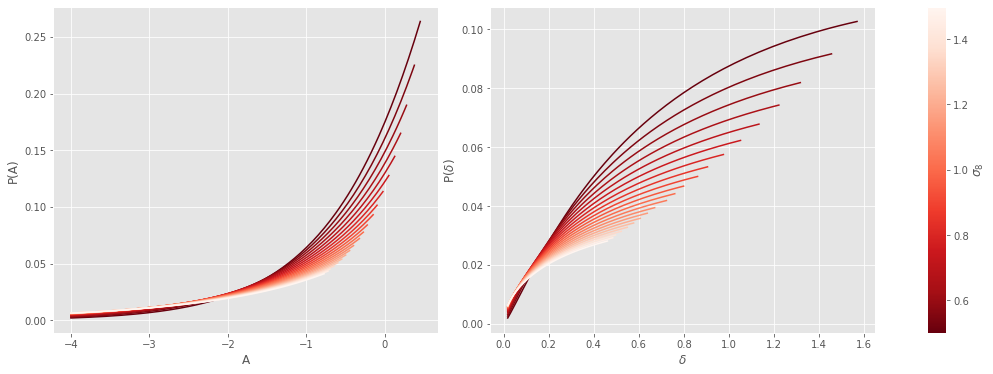

In [18]:
def draw_ldeltaDistr():
    """ draw the log field distribution function. """

    def _ldelta_distr(x: float, sigma8: float) -> float:
        return test_ldeltaDistr(x, 1.95, c, sigma8)

    s8  = np.linspace(0.5, 1.5, 21)

    # creating a colormap
    from matplotlib import colors, cm 
    cmap = cm.ScalarMappable(
                                norm = colors.Normalize(s8.min(), s8.max(), ),
                                cmap = cm.Reds_r
                            )
    cmap.set_array([])

    x  = np.linspace(-4.0, 1.0, 201)
    ex = np.exp(x)                    # 1 + delta

    fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize = (16, 6), 
                                        gridspec_kw = {"width_ratios":[1, 1, 0.05]})


    for sigma8 in s8:
        px   = _ldelta_distr(x, sigma8)
        mask = (px > 0.0)
        ax1.plot(x[mask], px[mask], '-', color = cmap.to_rgba(sigma8))

        # TODO: check if the conversion is correct
        ax2.plot(ex[mask], px[mask] / (1 + ex[mask]), '-', color = cmap.to_rgba(sigma8))

    ax1.set_xlabel('A'); ax1.set_ylabel('P(A)')
    ax2.set_xlabel('$\\delta$'); ax2.set_ylabel('P($\\delta$)')

    plt.colorbar(cmap, cax = cax, orientation = "vertical")
    cax.set_ylabel('$\\sigma_8$')

    plt.show()

draw_ldeltaDistr()